# Quantum Fourier Transform 
QFT is related to **rotations**; every operation on a single qubit can be viewed as rotation(primarily about the z-axis) on the Bloch-sphere. <br>
Why we should work with the QFT at all? There are other procedures that could be used to perform these basic operations; for example, by imitating the classical algorithm. But it has already been proven that the QFT needs fewer qubits to perform these operations, which is nowadays of vital importance. <br>

### Rotation
The gate $Z_{\phi}$ represents rotation by angle$\phi$ about the z-axis. Action of any gate can fully be specified by giving the action of the gate on the computational basis. $Z_{\phi}$ keeps state 0 unchanged but multiplies the state 1 by a phase factor $e^{i \phi}$; $Z_{\phi}\ket{0}=\ket{0}$, $Z_{\phi}\ket{1}=e^{i \phi}\ket{1}$ <br>
Matrix representation: $ Z_{\phi} = \begin{bmatrix} 1 & 0 \\ 0 & e^{i \phi} \end{bmatrix}$ <br>
QFT uses a discretized family of $Z_{\phi}$ gates, called $Z_{k}$ gates. For a given positive number k, the $Z_{k}$ gate rotates the state about z-axis by an angle of $\frac{2\pi}{2^{k}}$ <br>
Matrix representation: $ Z_{k} = \begin{bmatrix} 1 & 0 \\ 0 & e^{\frac{2\pi\iota}{2^{k}}} \end{bmatrix}$ <br>

### QFT Representation 
**Computational basis** <br>
If we have n qubits, we will be able to represent the numbers from 0 to $2^{n}−1$ <br>
A binary number can be represented as a string of 1s and 0s, which we can represent as the multi-qubit state 
$\ket{m} = \ket{\overline{q_{0}q_{1}....q_{n-1}}}$ where the formula to obtain the equivalent decimal number m will be:
$m = \sum_{i=0}^{n-1}2^{n-i-1}q_{i}$. Note that $\ket{m}$ refers to the basic state generated by the binary encoding of the number m.

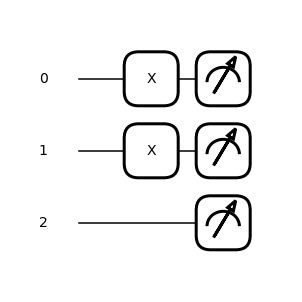

In [1]:
#  qml.BasisEmbedding(features, wires)[Encodes n binary features into a basis state of n qubits] template to obtain the binary representation of the number 6
import pennylane as qml
import matplotlib.pyplot as plt

dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
@qml.compile()
def basis_embedding_circuit(m):
    qml.BasisEmbedding(m, wires=range(3)) # features = binary input of shape (len(wires), ) or the number in decimal 
    return qml.state()

m = 6 # number to be encoded

qml.draw_mpl(basis_embedding_circuit, show_all_wires=True)(m)
plt.show()

**Fourier basis** <br>
We can also represent the numbers in different bases, such as the so-called Fourier base. In this case, all the states of the basis will be represented via qubits in the XY-plane of the Bloch sphere, each rotated by a certain amount. How do we know how much we must rotate each qubit to represent a certain number? Suppose we are working with n qubits and we want to represent the number m in the Fourier basis. Then the j-th qubit will have the phase: $\alpha_{j} = \frac{2m\pi}{2^{j}}$ <br>
Why Fourier basis? The fact that the states encoding the numbers are now in phase gives us great flexibility in carrying out our arithmetic operations.

**Adding a number to a register** <br>
Create an operator Sum such that: $Sum(k)\ket{m} = \ket{m+k}$ <br>
The procedure to implement this unitary operation is the following:
1. We convert the state from the computational basis into the Fourier basis by applying the QFT to the $\ket{m}$ state via the QFT operator.
2. We rotate the j-th qubit by the angle $\frac{2k\pi}{2^{j}}$ using the $R_{Z}$ gate, which leads to the new phases, $\frac{2(m+k)\pi}{2^{j}}$
3. We apply the QFT inverse to return to the computational basis and obtain $m+k$

In [2]:
import pennylane as qml
from pennylane import numpy as np

n_wires = 4
dev = qml.device("default.qubit", wires=n_wires, shots=1)

def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

@qml.qnode(dev)
def sum(m, k):
    qml.BasisEmbedding(m, wires=range(n_wires))  # m encoding

    qml.QFT(wires=range(n_wires))  # step 1

    add_k_fourier(k, range(n_wires))  # step 2

    qml.adjoint(qml.QFT)(wires=range(n_wires))  # step 3

    return qml.sample()


print(f"The ket representation of the sum of 3 and 4 is {sum(3,4)}")

The ket representation of the sum of 3 and 4 is [0 1 1 1]


**Adding a number to a register**  <br>
$Sum_{2}\ket{m}\ket{k}\ket{0} = \ket{m}\ket{k}\ket{m+k}$ <br>
In this case, we can understand the third register (which is initially at $0$) as a counter that will tally as many units as m and k combined. The binary decomposition will make this simple. If we have $\ket{m} = \ket{\overline{q_{0}q_{1}q_{2}}}$ we will have to add 1 to the counter if $q_{2}=1$ and nothing otherwise. In general, we should add $2^{n-i-1}$ units if the i-th qubit is in state $\ket{1}$ and 0 otherwise. As we can see, this is the same idea that is also behind the concept of a controlled gate. Indeed, observe that we will, indeed, apply a corresponding phase if indeed the control qubit is in the state $\ket{1}$

The ket representation of the sum of 7 and 3 is [1 0 1 0]


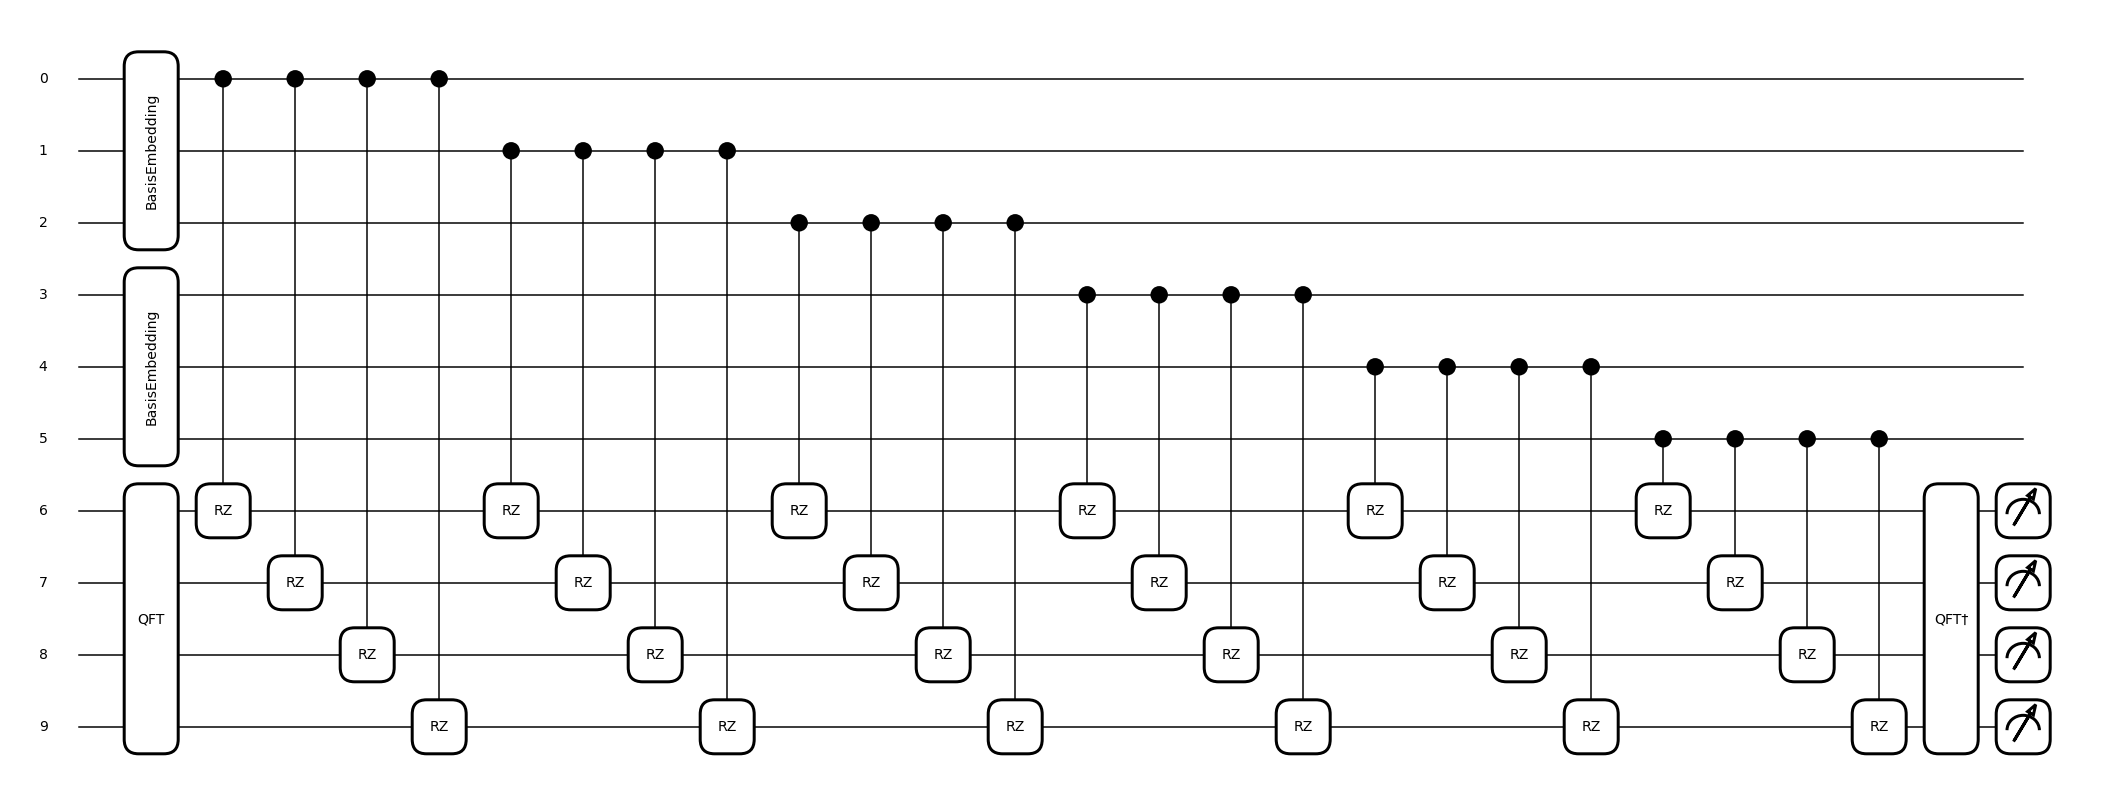

In [3]:
# code for the Sum_{2} operator
wires_m = [0, 1, 2]             # qubits needed to encode m
wires_k = [3, 4, 5]             # qubits needed to encode k
wires_solution = [6, 7, 8, 9]   # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)

n_wires = len(dev.wires) # total number of qubits used

def addition(wires_m, wires_k, wires_sol):
    # prepare solution qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_m)):
        qml.ctrl(add_k_fourier, control=wires_m[i])(2 **(len(wires_m) - i - 1), wires_solution)

    # add k to the counter
    for i in range(len(wires_k)):
        qml.ctrl(add_k_fourier, control=wires_k[i])(2 **(len(wires_k) - i - 1), wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def sum2(m, k, wires_m, wires_k, wires_solution):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # apply the addition circuit
    addition(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)

print(f"The ket representation of the sum of 7 and 3 is "
      f"{sum2(7, 3, wires_m, wires_k, wires_solution)}")

qml.draw_mpl(sum2, show_all_wires=True)(7, 3, wires_m, wires_k, wires_solution)
plt.show()

**Multiplying qubits**  <br>
$Mul\ket{m}\ket{k}\ket{0} = \ket{m}\ket{k}\ket{m\cdot k}$ <br>

The ket representation of the multiplication of 3 and 7 is [1 0 1 0 1]


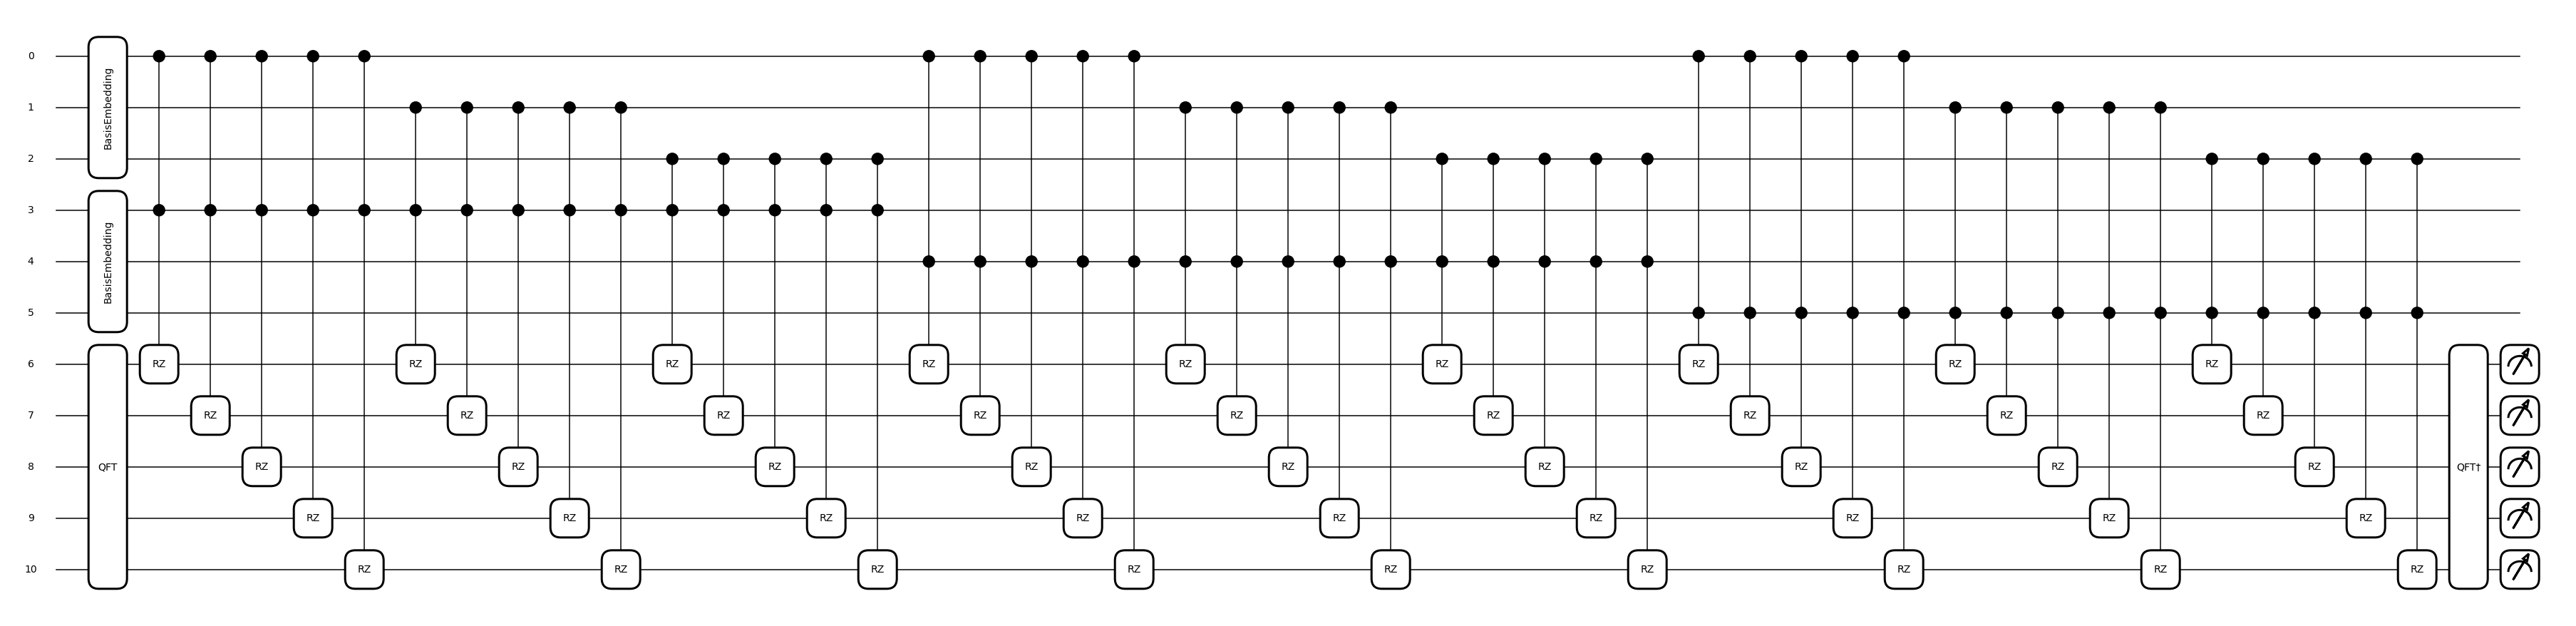

In [4]:
wires_m = [0, 1, 2]           # qubits needed to encode m
wires_k = [3, 4, 5]           # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10]  # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)

n_wires = len(dev.wires)

def multiplication(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            coeff = 2 ** (len(wires_m) + len(wires_k) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[i], wires_m[j]])(coeff, wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def mul(m, k):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # Apply multiplication
    multiplication(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)


print(f"The ket representation of the multiplication of 3 and 7 is {mul(3,7)}")

qml.draw_mpl(mul, show_all_wires=True)(3, 7)
plt.show()

### References 
__[link](https://pennylane.ai/qml/demos/tutorial_qft_arithmetics.html#draper2000)__